To enable interactive plots, run `jupyter labextension install jupyter-matplotlib` followed by:

In [1]:
!jupyter labextension install jupyter-matplotlib

Building jupyterlab assets (production, minimized)


In [2]:
!pip install --upgrade ipympl matplotlib -q
%matplotlib ipympl

In [3]:
!pip install hdbscan pymatgen colorcet -q

In [4]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../autoencoder')

from src.band_plotters import*
from src.TensorImageNoised import *
from src.cluster_plotters import *
sys.path.append('/notebooks/band-fingerprint/autoencoder/')
sys.path.append('/notebooks/band-fingerprint/src')

from model import *
import model as resnet_autoencoder

from ae_misc import *

%matplotlib inline
#%matplotlib auto

# Enter Full Fingerprint Name - Specify Configuration Below
Note perplexity can be changed for second tsne run - see configuration. See `fingerprints` folder to view possible `FINGERPRINT_NAME`'s.

In [5]:
FINGERPRINT_NAME = "224_2channel_resnet_L=98_perplexity_30_length_98"

# Functions to View Materials/Clusters

For any fingerprint

In [6]:
def view_material_any(index, show_inp=False):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, fp_dict["length"], fp_dict["length"]), df.loc[index][fingerprint_cols])
    ax.set_xlabel(index)
    ax.set_title("fingerprint")
    plt.show()
    
    if show_inp:
        image = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        image.show()

For an autoencoder based fingerprint

In [7]:
def show_tensor_image(tensor, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(tensor.permute(1, 2,0).detach().numpy(), vmax=1, vmin=0)
    return ax

def view_material_ae_2_channel(index, inp_recon_together=False):
    view_material_any(index)
        
    print(df.loc[index]["member_strength"])

    image_filename = DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png"

    if learn:
        # Get input and prediction
        _, out, _ = learn.predict(image_filename)


        # 2 channel image
        dl = learn.dls.test_dl([image_filename])

        with torch.no_grad():
            inp = dl.one_batch()[0]
            fingerprint_2_channel = learn.model.encoder(inp)

        fingerprint_2_channel = fingerprint_2_channel[0]
        fingerprint_2_channel /= 3.982462167739868 # max activation in fingerprint array
        rgb_image = torch.stack([fingerprint_2_channel[0, :, :], torch.zeros_like(fingerprint_2_channel[0, :, :]), fingerprint_2_channel[1, :, :]], dim=0)
        show_tensor_image(rgb_image)

        ax = None
        if inp_recon_together:
            fig, ax = plt.subplots(2, 1)

        show_tensor_image(inp[0], ax)
        show_tensor_image(torch.sigmoid(out), ax)
        plt.show()
    else:
        print(f"Model not loaded, displaying bandstructure of {index}:")
        show_image(load_image(image_filename))


In [8]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(200))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        view_material_function(index)

# Fingerprint Configurations

In [9]:
FINGERPRINTS = {
    "224_2channel_resnet_L=98_perplexity_30_length_98":{
    "hdbscan":{"min_cluster_size":6, "min_samples":2},
    "tsne":{"perplexity":10, "early_exaggeration":12.0, "learning_rate":"auto"},
    "length":98,
    "model": "../autoencoder/trained_models/resnet18_size224_lossbce_channels2.pkl",
    "view_func":view_material_ae_2_channel
    },
    
    "all_k_branches_histogram_-8_to_8_perplexity_30_length_60":{
    "hdbscan":{"min_cluster_size":4, "min_samples":3},
    "tsne":{"perplexity":30, "early_exaggeration":12.0, "learning_rate":"auto"},
    "length":60,
    "model":False,
    "view_func":lambda mat_id: view_material_any(mat_id, True) 
    }
    
}

fp_dict = FINGERPRINTS[FINGERPRINT_NAME]
hdbscan_dict = fp_dict["hdbscan"]
tsne_dict = fp_dict["tsne"]
length = fp_dict["length"]
view_material_function = fp_dict["view_func"]


FLAT_ONLY = True
BORING_COLUMNS = ["flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = FINGERPRINT_NAME + ".csv"

In [10]:
try:
    if fp_dict["model"]:
        learn = load_learner(fp_dict["model"])
except:
    learn = None
    print("Model not found")

Model not found


# Load Data

In [11]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,90,91,92,93,94,95,96,97,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,...,2.325100,1.733577,1.816098,1.953408,1.904952,1.718350,1.920829,1.940830,-17.031164,-22.583645
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,...,2.226489,2.289640,2.589102,2.477097,2.594307,2.217409,2.636327,2.281451,-85.320190,19.231680
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,...,2.502424,1.772349,1.775590,1.941162,1.745729,1.716548,1.714002,1.817789,74.049220,-91.258260
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,...,2.372130,2.224227,2.399812,2.197275,2.769758,2.584419,2.809708,2.114330,36.688946,55.726463
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,...,2.852715,2.168420,2.470804,2.357963,2.278249,2.280239,2.296243,2.235125,11.995536,-106.832634


# Cluster

In [12]:
fingerprint_cols = [str(i) for i in range(length)]
BORING_COLUMNS += fingerprint_cols

In [13]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
gen_min_span_tree=True, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=hdbscan_dict["min_cluster_size"], min_samples=hdbscan_dict["min_samples"], p=0.2)

clusterer.fit(df[fingerprint_cols])


df["labels"] = clusterer.labels_
df["member_strength"] = clusterer.probabilities_


# View Clusters

In [14]:
%matplotlib inline


interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interactive(children=(IntSlider(value=16, description='label', max=33, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

# Run TSNE and plot (with draggable labels)

In [15]:
if FLAT_ONLY:
    # tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate="auto", random_state=0, perplexity=10,n_iter=10000, verbose=2, metric="minkowski")
    tsne = manifold.TSNE(n_components=2, early_exaggeration=tsne_dict["early_exaggeration"], init="pca",learning_rate=tsne_dict["learning_rate"], random_state=0, perplexity=tsne_dict["perplexity"],n_iter=10000, verbose=2)
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.002s...
[t-SNE] Computed neighbors for 2005 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 1.019422
[t-SNE] Computed conditional probabilities in 0.026s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 74.6053772, gradient norm = 0.0123159 (50 iterations in 0.428s)
[t-SNE] Iteration 100: error = 75.4825897, gradient norm = 0.0099334 (50 iterations in 0.597s)
[t-SNE] Iteration 150: error = 76.0996246, gradient norm = 0.0045396 (50 iterations in 0.394s)
[t-SNE] Iteration 200: error = 76.4148178, gradient norm = 0.0026537 (50 iterations in 0.407s)
[t-SNE] Iteration 250: error = 76.4638901, gradient norm = 0.0028607 (50 iterations in 0.422s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.463890
[t-SNE] Iteration 300: error = 2.3112350, gradient norm = 0.0024505 (50 iterations in 0.353s)
[t-SNE] Iteration 350: error = 1.8639212, gradient norm = 0.0010709 (50 iterations in 0.743s)
[t-SNE] Iteration 400: error = 1.6555762, gradient norm = 0.0006331 (50 iterations in 1.501s)
[t-SNE] Iteration 450: error = 1.5371761, gradient norm = 0.0004404 (50 iterations in 1.259s)
[t-SNE] Iteration 500: error = 1.4631188, gradient norm = 0.0003249 (50 

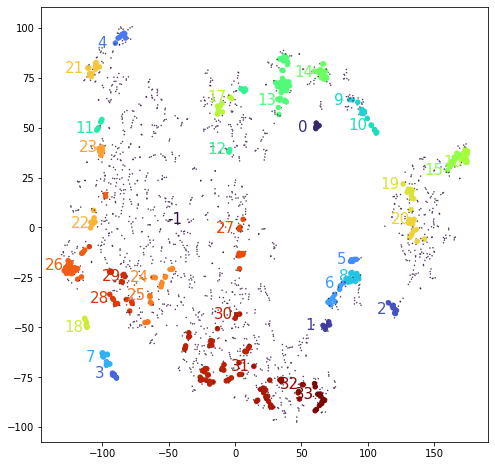

In [16]:
%matplotlib inline
labels = clusterer.labels_

fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*20
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprint_2d[rep_id,:]+[-10,0],color=col,alpha=1, weight='normal', ha='center', va='center', size=15).draggable()

plt.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")


plt.show()



# View Groups Simulataneously With Clusters
Click on a point to it's cluster number, fingerprint, band structure and reconstruction if applicable.

Output()

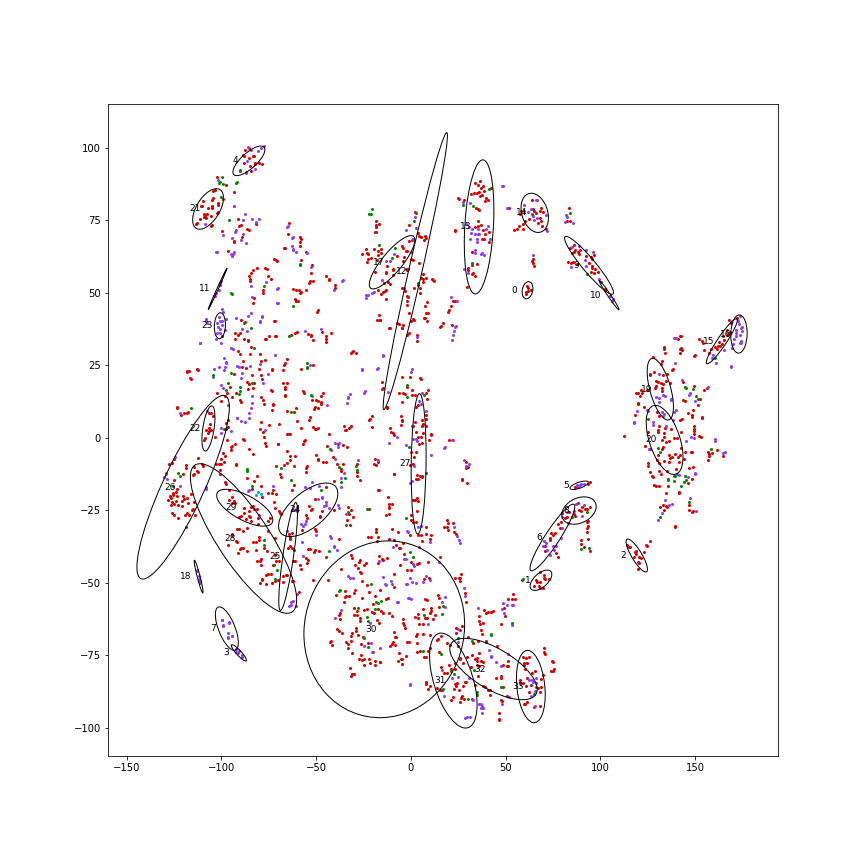

In [18]:
# change to ipympl for interactive plot (ie so you can click on materials)

%matplotlib inline 
group = "segments" # of k-branches

%matplotlib ipympl
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    # display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
    plt.close()
    %matplotlib inline
    view_material_function(closest)
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df, group, ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# Output table of all clusters with chemical formulae (+ exemplar material band structures for machine learned print)

In [24]:
from pandas.plotting import table

In [25]:
df.formula[1]
def round_(number):
    return round(number, 5)
df["member_strength"] = df.member_strength.apply(round_)

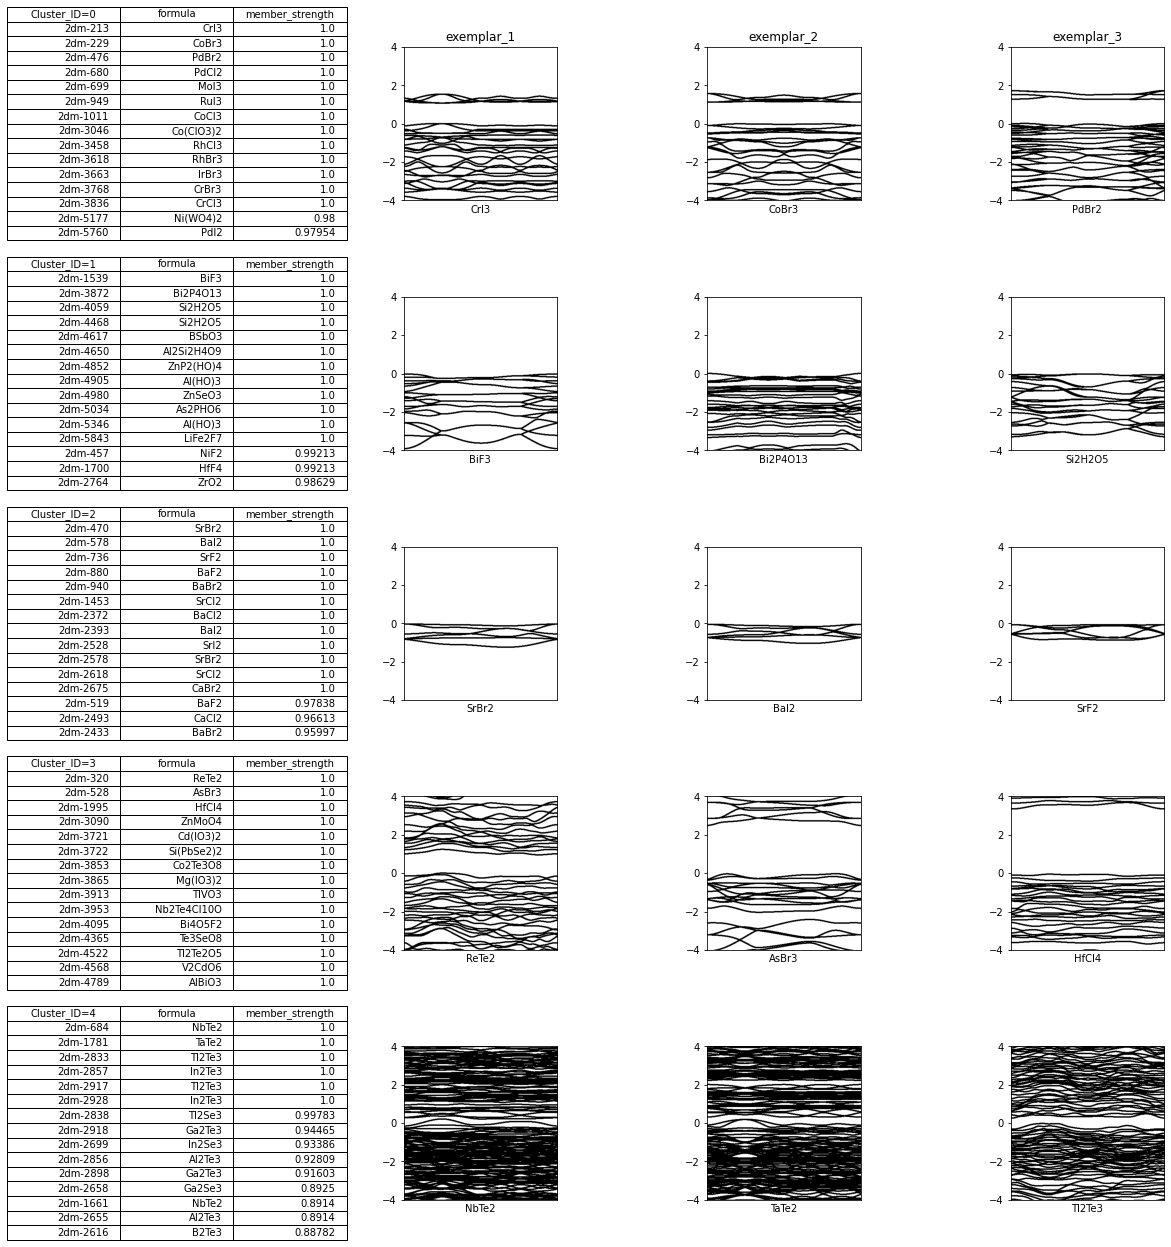

In [26]:
sorted_cluster_df = df[df.labels!=-1].sort_values(by=['labels','member_strength'], ascending=[True, False])

N_clusters = len(np.unique(clusterer.labels_))-1
#N_clusters = 6

num_bands = 3
fig, axs = plt.subplots(N_clusters, num_bands+1, figsize=(17,3.5*N_clusters))

# for machine learned print
for i in range(1,num_bands+1):
    axs[0, i].set_title('exemplar_{0}'.format(i))

for i in range(0, N_clusters):
    
    
    df_part1 = sorted_cluster_df[sorted_cluster_df.labels==i][["formula", "member_strength"]]
    # min table size of 15
    if(len(df_part1)>=15):
        df_part1 = df_part1.head(15)
    
    #axs[i, 0].set_title('Cluster_ID={0}'.format(i), y=0.95)
    axs[i, 0].axis("off")
    
    # add band structures for the machine learned fingerprint tables
    # plot the input bands:
    input_bands_1 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[0]}.png")
    input_bands_2 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[1]}.png")
    input_bands_3 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[2]}.png")

    axs[i,1].imshow(input_bands_1, extent=[-4, 4, -4, 4], aspect=1)
    axs[i,2].imshow(input_bands_2, extent=[-4, 4, -4, 4], aspect=1)
    axs[i,3].imshow(input_bands_3, extent=[-4, 4, -4, 4], aspect=1)
    
    #axs[i, 0].set_position([0.0, 0.0, 0.25, 0.25])
    for j in range(1, num_bands+1):
        #axs[i, 0].set_position([0.0, 0.0, 0.5, 0.5])
        axs[i, j].set_xlabel(df_part1.formula[j-1])
        axs[i,j].tick_params(axis='x', which='both',bottom=False,top=False,labelbottom=False)
    
    df_part1_with_index_label = df_part1.rename_axis('Cluster_ID={0}'.format(i)).reset_index()
    table = axs[i, 0].table(df_part1_with_index_label.values, colLabels=df_part1_with_index_label.columns, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Adjust font size as needed
    table.scale(1.3, 1.3)  # Scale up the table size


fig.tight_layout()    
#plt.subplots_adjust(wspace=0.2)   
plt.savefig("corrected_alpha_1.0_MCS_6_MS_2_clusters_big_table.png")
plt.show()

# 2D HISTOGRAM FOR HDBSCAN PARAMETER OPTIMISATION

In [27]:
# iterate over hdbscan parameter values
MS_vals = np.arange(2,12,1)
MCS_vals = np.arange(2,12,1)

DBCV_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_cluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_uncluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))

for i,MS in enumerate(MS_vals):
    for j,MCS in enumerate(MCS_vals):
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                                gen_min_span_tree=True, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=MCS, min_samples=MS, p=0.2)
        #clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
        clusterer.fit(df[fingerprint_cols])

        df["labels"] = clusterer.labels_
        
        DBCV_vals[-(j+1),i] = clusterer.relative_validity_ 
        N_cluster_vals[-(j+1),i] = len(np.unique(clusterer.labels_))-1
        N_uncluster_vals[-(j+1),i] = len(df[df["labels"]==-1])

        

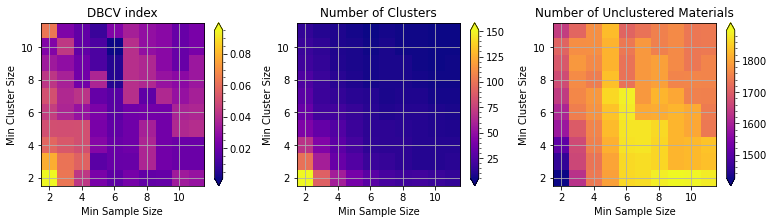

In [28]:
import matplotlib as mpl
# generate plots
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)


# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow
pos = ax1.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5], cmap=mpl.colormaps["plasma"])

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar3 = fig.colorbar(pos, ax=ax1, extend='both')

# repeat everything above for the negative data
# you can specify location, anchor and shrink the colorbar
neg = ax2.imshow(N_cluster_vals, extent=[1.5,11.5,1.5,11.5], cmap=mpl.colormaps["plasma"])
cbar2 = fig.colorbar(neg, ax=ax2, extend='both')



# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = ax3.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5], cmap=mpl.colormaps["plasma"])
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar1 = fig.colorbar(pos_neg_clipped, ax=ax3, extend='both')
cbar1.minorticks_on()
cbar2.minorticks_on()
cbar3.minorticks_on()

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")
ax1.grid()
ax1.set_title("DBCV index")

ax2.set_xlabel("Min Sample Size")
ax2.set_ylabel("Min Cluster Size")
ax2.grid()
ax2.set_title("Number of Clusters")

ax3.set_xlabel("Min Sample Size")
ax3.set_ylabel("Min Cluster Size")
ax3.grid()
ax3.set_title("Number of Unclustered Materials")

plt.savefig("corrected_2d_hist_hdbscan_params", dpi=100, bbox_inches="tight")
plt.show()
